In [1]:
import sys, os
print('Python:  ', sys.version)
print('Active Conda Environment: ', os.getenv('CONDA_DEFAULT_ENV'))

Python:   3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]
Active Conda Environment:  pyarima


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
airline = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
airline.index.freq='MS'
airline = airline.dropna()
airline.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### SMA
#### Simple Moving Average

We've already shown how to create a <a href='https://en.wikipedia.org/wiki/Moving_average#Simple_moving_average'>simple moving average</a> by applying a <tt>mean</tt> function to a rolling window.
For a quick review:

In [4]:
airline['6-month-SMA'] = airline['#Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['#Passengers'].rolling(window=12).mean()

In [5]:
airline.head(13)

,#Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


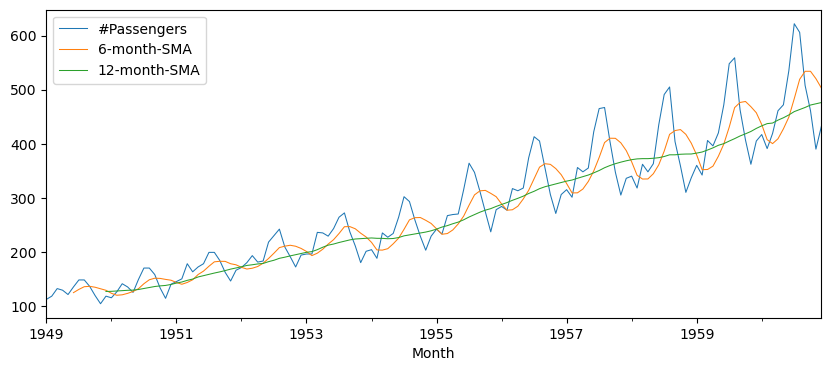

In [6]:
airline.plot(figsize=(10,4), linewidth=0.75)
plt.show()

### Forecast using SMA

In [7]:
airline2 = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
airline2.index.freq='MS'
airline2 = airline2.dropna()
airline2.shape

(144, 1)

In [8]:
airline2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [9]:
train = airline2[0:120] 
test = airline2[120:]

In [10]:
train = airline2[0:120].copy()
test = airline2[120:]

window_size = 12
sma = train['#Passengers'].rolling(window_size).mean()
for i in range(24):
    forecast = sma.iloc[-1]
    last_date = train.index[-1]
    last_date1 = last_date + pd.DateOffset(months=1)
    train.loc[last_date1, '#Passengers'] = forecast
    sma = train['#Passengers'].rolling(window_size).mean()

In [11]:
df2 = pd.DataFrame()
df2.index=airline2.index
df2['train'] = train[0:120] 
df2['forecast'] = train[120:] 
df2['actual'] = test

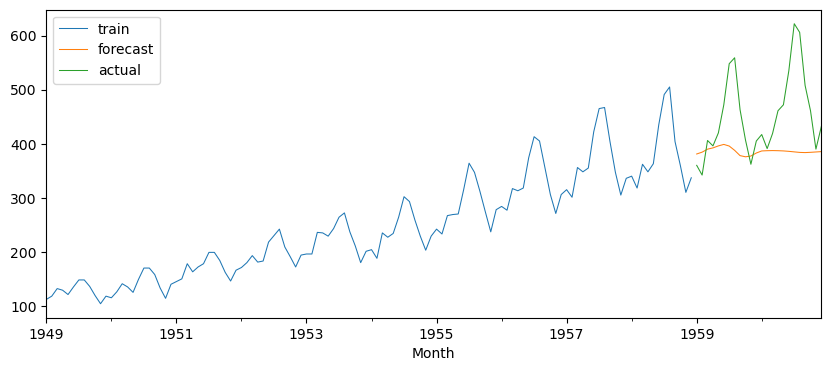

In [12]:
df2.plot(figsize=(10,4), linewidth=0.75)
plt.show()

### Simple Exponential Smoothing
The above example employed <em>Simple Exponential Smoothing</em> with one smoothing factor <strong>α</strong>. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above. In the next section we'll look at Holt-Winters Methods.

In [13]:
from statsmodels.tsa.api import SimpleExpSmoothing 

In [14]:
airline2 = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
airline2.index.freq='MS'
airline2 = airline2.dropna()
airline2.shape

(144, 1)

In [15]:
alpha=0.2
fit02 = SimpleExpSmoothing(airline2).fit(smoothing_level=alpha, optimized=False)
fitted02 = fit02.fittedvalues
alpha=0.6
fit06 = SimpleExpSmoothing(airline2).fit(smoothing_level=alpha, optimized=False)
fitted06 = fit06.fittedvalues

In [16]:
airline3 = airline2.copy()
airline3['ses(α=0.6)'] = fitted06
airline3['ses(α=0.2)'] = fitted02

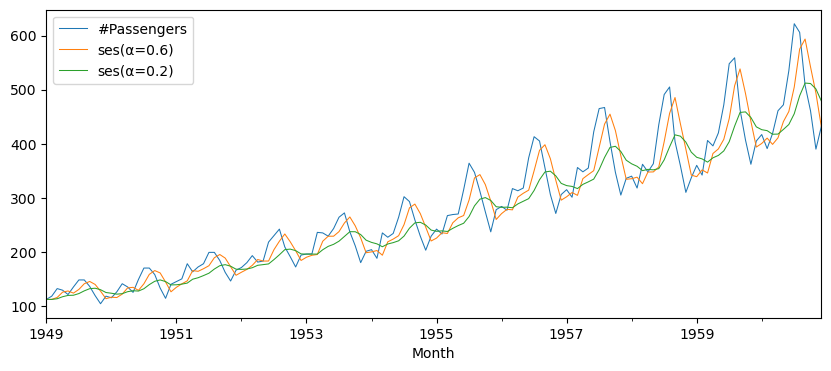

In [17]:
airline3.plot(figsize=(10,4), linewidth=0.75)
plt.show()

In [18]:
train = airline2[0:120] 
test = airline2[120:]

In [19]:
alpha=0.6
fit1 = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
fcast1 = fit1.forecast(24).rename(r'$\alpha={}$'.format(alpha))

In [20]:
fcast1.index = test.index
df2 = pd.DataFrame()
df2.index=airline2.index
df2['train'] = train[0:120] 
df2['forecast'] = fcast1
df2['actual'] = test

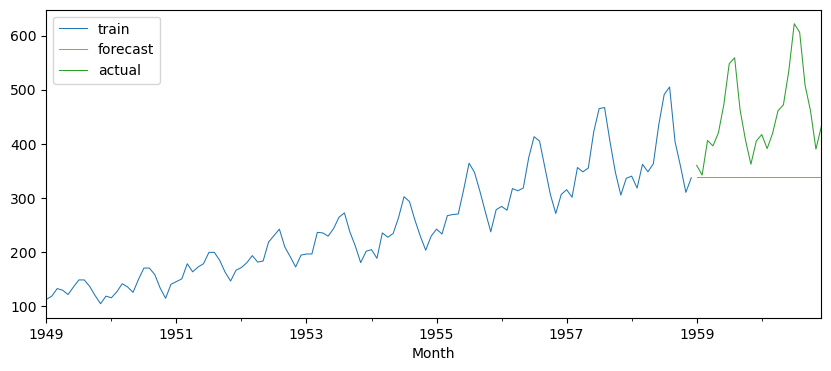

In [21]:
df2.plot(figsize=(10,4), linewidth=0.75)
plt.show()

### Holt-Winters

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [23]:
airline2 = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
airline2.index.freq='MS'
airline2 = airline2.dropna()
airline2.shape

(144, 1)

In [24]:
train = airline2[0:120] 
test = airline2[120:]

In [25]:
hw = ExponentialSmoothing(train['#Passengers'], trend='add',
                        seasonal='add', seasonal_periods=12).fit(optimized=True)
fcast1 = hw.forecast(len(test))

In [26]:
fcast1.index = test.index
df2 = pd.DataFrame()
df2.index=airline2.index
df2['train'] = train[0:120] 
df2['forecast'] = fcast1
df2['actual'] = test

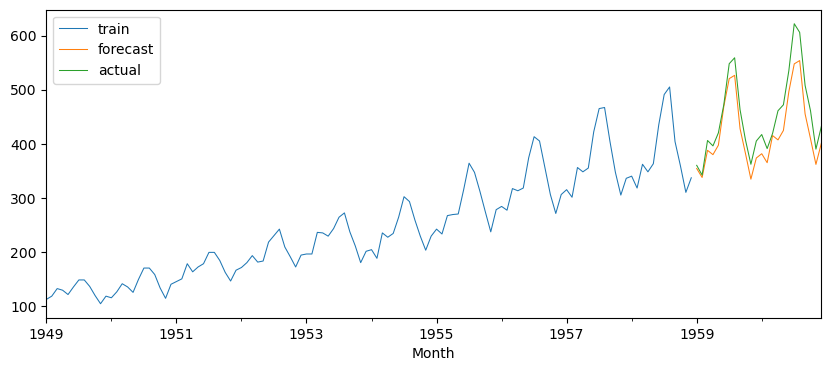

In [27]:
df2.plot(figsize=(10,4), linewidth=0.75)
plt.show()

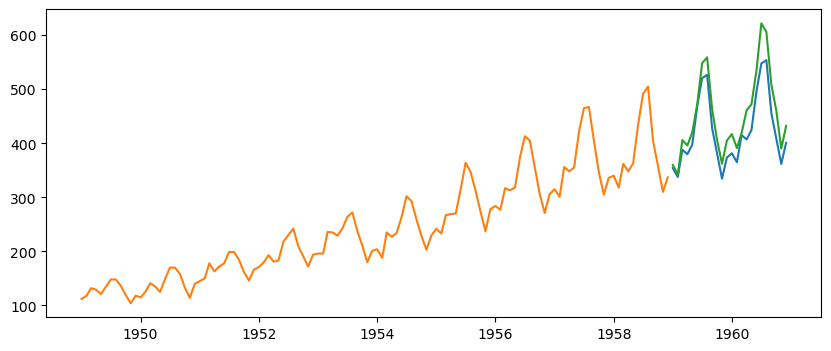

In [28]:
plt.figure(figsize=(10,4))
plt.plot(fcast1)
plt.plot(train)
plt.plot(test)
plt.show()

## Residual Analysis

In [29]:
# Appending residuals and fitted values to the train dataframe
train = train.copy()
train.loc[:,'fittedvalues'] = hw.fittedvalues
train.loc[:,'residuals'] = hw.resid
train.head()

,#Passengers,fittedvalues,residuals
Month,,,
1949-01-01,112,111.971614,0.028386
1949-02-01,118,119.838897,-1.838897
1949-03-01,132,134.255575,-2.255575
1949-04-01,129,131.010976,-2.010976
1949-05-01,121,124.184838,-3.184838


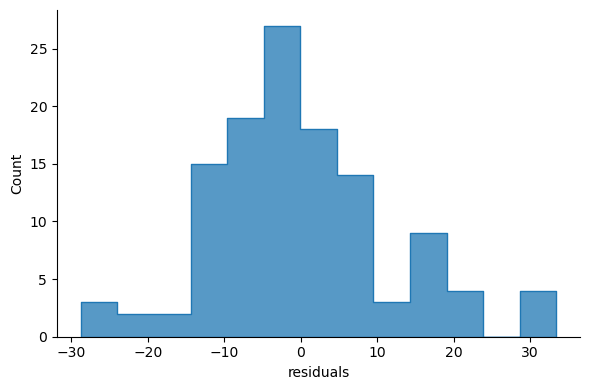

In [30]:
import seaborn as sns
sns.displot(data=train, x="residuals", height=4, aspect=1.5, element='step')
plt.show()

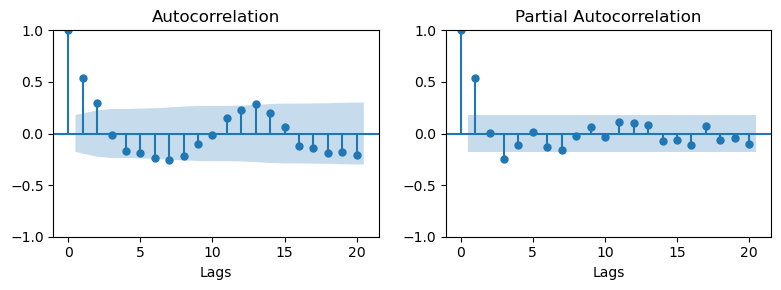

In [31]:
# Import packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_acf(train['residuals'], lags=20, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(train['residuals'], lags=20, ax=ax[1], method='ywm')
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

### Ljung-Box Test

In [32]:
# Import packages
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carry out Ljung-Box test
print(acorr_ljungbox(train['residuals'], return_df=True))

      lb_stat     lb_pvalue
1   35.943369  2.031365e-09
2   46.955636  6.363751e-11
3   46.966818  3.532553e-10
4   50.514408  2.819578e-10
5   55.122810  1.231585e-10
6   62.069811  1.707465e-11
7   70.669061  1.082064e-12
8   76.632692  2.321917e-13
9   77.970711  4.084146e-13
10  77.983963  1.245546e-12


### Augmented Dickey-Fuller test

In [33]:
train = airline2.copy()

In [34]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### Differencing to remove Stationarity

In [35]:
train = train.copy()
train['diff1'] = train['#Passengers'].diff()
train = train.dropna()

In [36]:
result = adfuller(train['diff1'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


### ACF - PACF on AirPassengers Data

In [37]:
df = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
df.index.freq='MS'

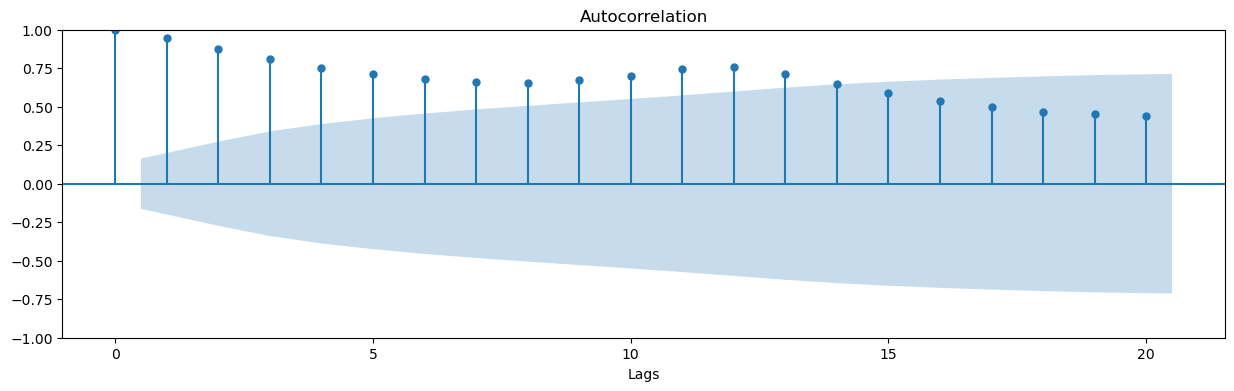

In [38]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 4))
plot_acf(df, lags=20, ax=ax)
ax.set_xlabel('Lags')
plt.show()

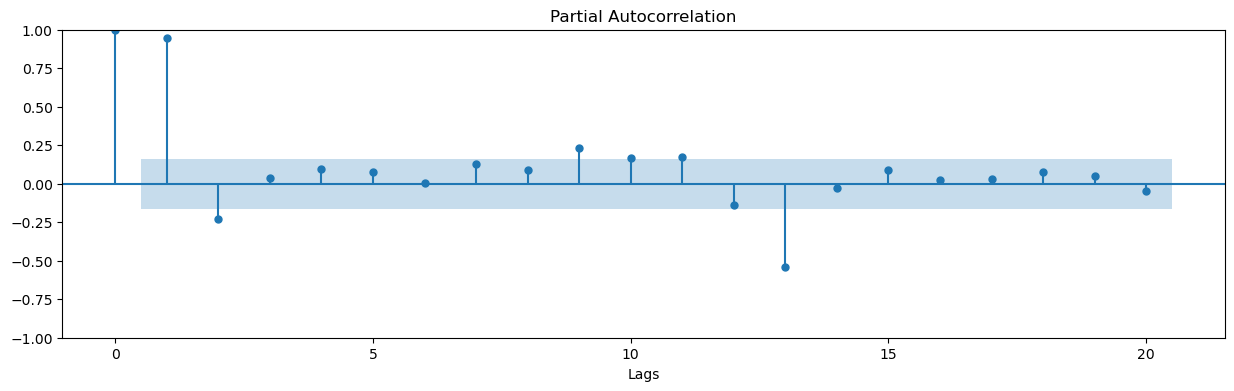

In [39]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_pacf(df, lags=20, ax=ax, method='ywm')
ax.set_xlabel('Lags')
plt.show()